# Student Performance Bayesian Network

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import PC, TreeSearch

random_state = 42

Data from the [UCI Student Performance](https://archive.ics.uci.edu/dataset/320/student+performance) dataset

In [139]:
# Importing data
df = pd.read_csv("data/student-mat.csv", sep=";")

# Unique values count for each feature
df.nunique()

school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      34
G1            17
G2            17
G3            18
dtype: int64

## Models

### Constraint-based: PC algorithm

  0%|          | 0/5 [00:00<?, ?it/s]

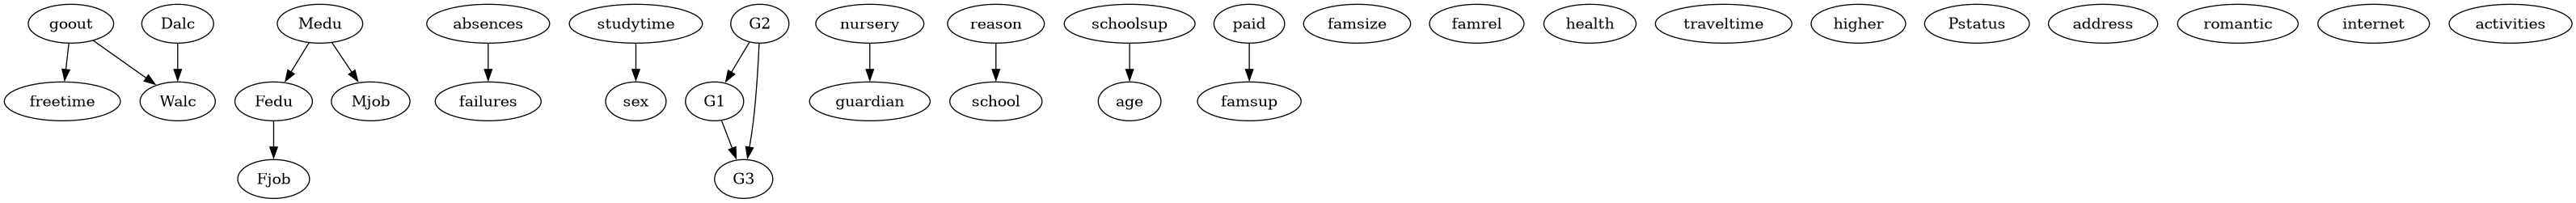

In [140]:
pc_dag = PC(df).estimate(return_type="dag", significance_level=0.2, random_state=random_state)  # PC algorithm

# Initializing bayesian network from DAG
pc_bn = BayesianNetwork()
pc_bn.add_nodes_from(pc_dag.nodes())
pc_bn.add_edges_from(pc_dag.edges())

# Plotting and storing network
pc_bn_graphviz = pc_bn.to_graphviz()
pc_bn_graphviz.draw("img/pc-bn.png", prog="dot")
Image(filename="img/pc-bn.png")

In [141]:
pc_bn.fit(df)

### Score-based: Tree Search

Building tree:   0%|          | 0/528.0 [00:00<?, ?it/s]

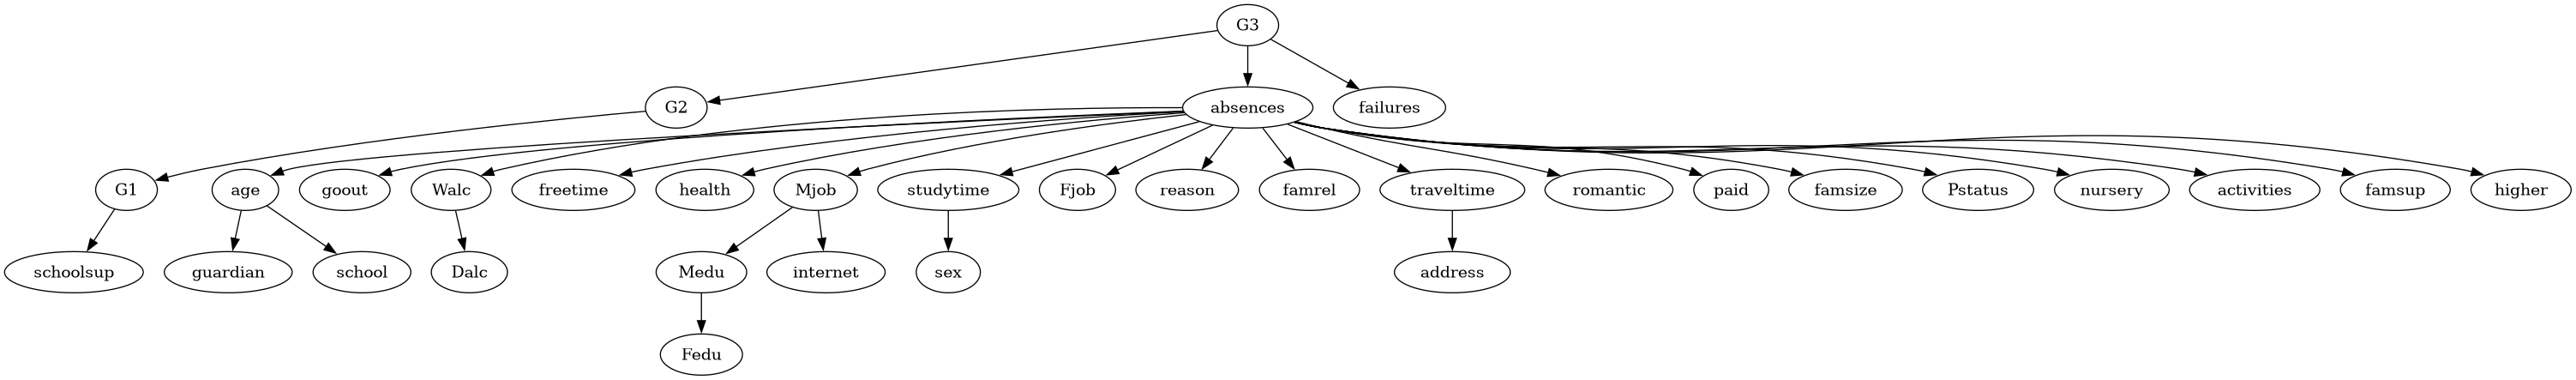

In [142]:
tree_dag = TreeSearch(df).estimate()  # Tree search

# Initializing bayesian network from DAG
tree_bn = BayesianNetwork()
tree_bn.add_nodes_from(tree_dag.nodes())
tree_bn.add_edges_from(tree_dag.edges())

# Plotting and storing network
tree_bn_graphviz = tree_bn.to_graphviz()
tree_bn_graphviz.draw("img/tree-bn.png", prog="dot")
Image(filename="img/tree-bn.png")

In [143]:
tree_bn.fit(df)

### Expert defined

Dropping features considered not highly relevant:
- school, reason: assuming student performances equivalent in different schools.
- address: home address type not considered relevant.
- famsize, guardian: family info already contained in other variables.
- nursery: attending nursery school not considered as relevant.
- G1, G2: interested only in the final grade.
    

In [144]:
expert_df = df.drop(
    [
        "school",
        "reason",
        "address",
        "famsize",
        "guardian",
        "paid",
        "nursery",
        "G1",
        "G2",
    ],
    axis=1,
)
expert_df.head()

,sex,age,Pstatus,Medu,Fedu,Mjob,Fjob,traveltime,studytime,failures,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,F,18,A,4,4,at_home,teacher,2,2,0,...,no,no,4,3,4,1,1,3,6,6
1,F,17,T,1,1,at_home,other,1,2,0,...,yes,no,5,3,3,1,1,3,4,6
2,F,15,T,1,1,at_home,other,1,2,3,...,yes,no,4,3,2,2,3,3,10,10
3,F,15,T,4,2,health,services,1,3,0,...,yes,yes,3,2,2,1,1,5,2,15
4,F,16,T,3,3,other,other,1,2,0,...,no,no,4,3,2,1,2,5,4,10


Aggregating features and values so to have smaller CPTs at the loss of some information detail

In [145]:
# Aggregating features: Considering student as socially active if they have a romantic partner or they meet friends regularly
expert_df["socially_active"] = (expert_df["romantic"] == "yes") | (
    expert_df["goout"] > 2
)
expert_df = expert_df.drop(["romantic", "goout"], axis=1)

In [146]:
# Making parents' education a boolean feature: True it's on par with the child's education (highschool) or greater, False otherwise
expert_df["Medu"] = expert_df["Medu"] >= 3
expert_df["Fedu"] = expert_df["Fedu"] >= 3

In [147]:
# Changing parents' job features to employed boolean features
expert_df["Mjob"] = expert_df["Mjob"] != "at_home"
expert_df["Fjob"] = expert_df["Fjob"] != "at_home"

In [148]:
# Re-binning absences to 0, 1, and 2 corresponding respectively to "Low", "Medium", "Hight"
def rebin_absences(x):
    if x < 10:  # Low number of absences
        return 0
    elif x < 20:  # Medium number of absences
        return 1
    else:  # High number of absences
        return 2


expert_df["absences"] = expert_df["absences"].apply(rebin_absences)

In [149]:
# Re-binning final grade column
def rebin_G3(x):
    if x < 10:  # Insufficient
        return 0
    elif x < 14:  # Sufficient
        return 1
    elif x < 18:  # Good
        return 2
    else:  # Excellent
        return 3


expert_df["G3"] = expert_df["G3"].apply(rebin_G3)

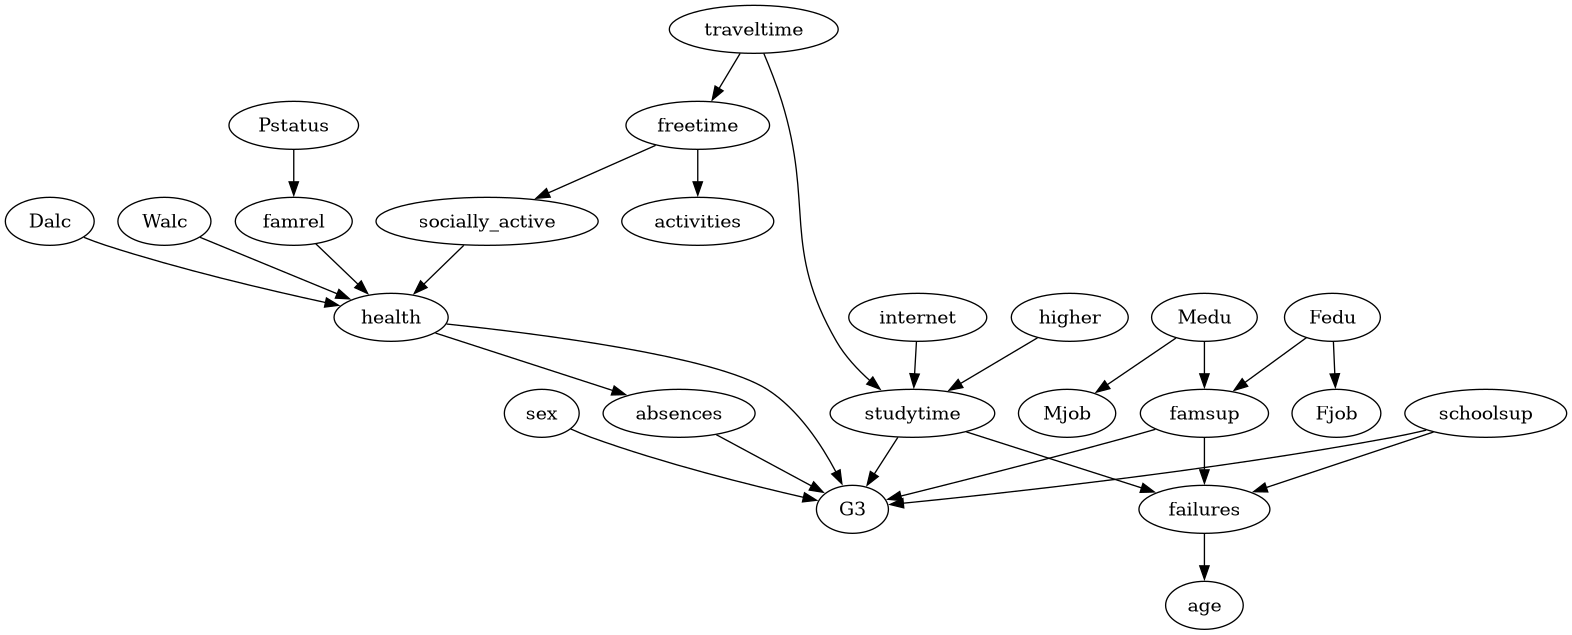

In [150]:
expert_bn = BayesianNetwork(
    [
        ("Pstatus", "famrel"),
        ("Medu", "Mjob"),
        ("Medu", "famsup"),
        ("Fedu", "Fjob"),
        ("Fedu", "famsup"),
        ("famsup", "failures"),
        ("schoolsup", "failures"),
        ("failures", "age"),
        ("famsup", "G3"),
        ("schoolsup", "G3"),
        ("traveltime", "studytime"),
        ("traveltime", "freetime"),
        ("internet", "studytime"),
        ("studytime", "failures"),
        ("studytime", "G3"),
        ("freetime", "socially_active"),
        ("freetime", "activities"),
        ("socially_active", "health"),
        ("health", "G3"),
        ("health", "absences"),
        ("absences", "G3"),
        ("Dalc", "health"),
        ("Walc", "health"),
        ("famrel", "health"),
        ("higher", "studytime"),
        ("sex", "G3"),
    ]
)

expert_bn_graphviz = expert_bn.to_graphviz()
expert_bn_graphviz.draw("img/expert-bn.png", prog="dot")
Image(filename="img/expert-bn.png")

In [151]:
expert_bn.fit(expert_df)

## Comparing the number of edges and the number of CPT entries

In [152]:
# Returns count of all the values stored in the CPDs of a network
# NOTE: pgmpy stores the full table
def count_network_cpt_entries(bayes_net: BayesianNetwork):
    entries_count = 0
    for cpd in bayes_net.get_cpds():  # cpd is a TabularCPD object
        entries_count += cpd.values.size
    return entries_count

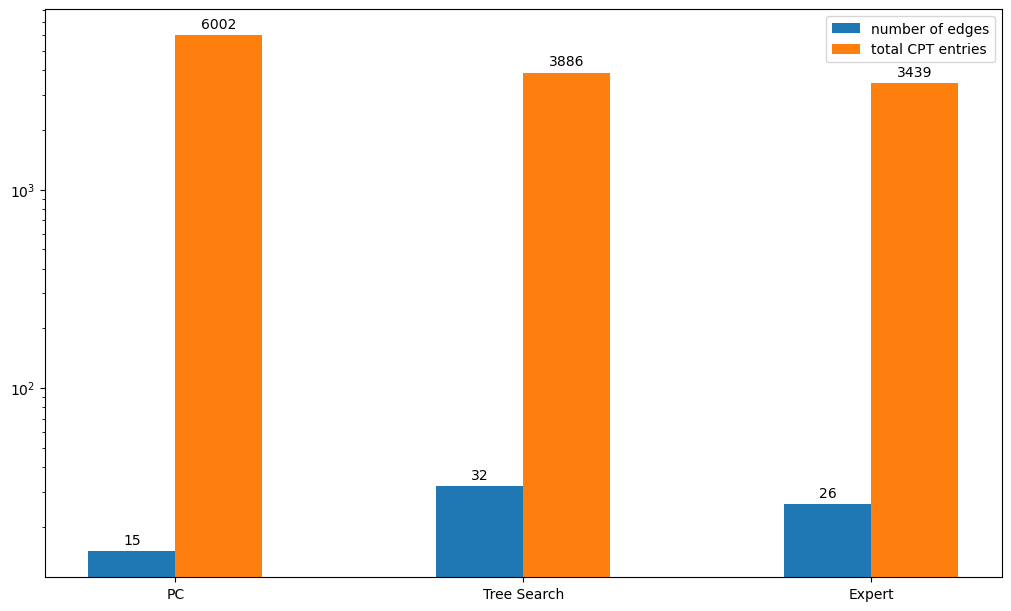

In [153]:
# Bar plot
networks = ("PC", "Tree Search", "Expert")
results = {
    "number of edges": (
        len(pc_bn.edges()),
        len(tree_bn.edges()),
        len(expert_bn.edges()),
    ),
    "total CPT entries": (
        count_network_cpt_entries(pc_bn),
        count_network_cpt_entries(tree_bn),
        count_network_cpt_entries(expert_bn),
    ),
}
x = np.arange(len(networks))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="constrained", figsize=(10, 6))

for attribute, measurement in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width/2, networks)
ax.set_yscale("log")
ax.legend()

plt.savefig("img/structure-comparison.png")
plt.show()

The reason for such a high number of CPT entries in the sparse, PC generated, Bayesian network are the edges between the high cardinality variables G1, G2, G3:

In [154]:
print(f"The CPT for the G3 variable holds {pc_bn.get_cpds("G3").values.size} entries")

The CPT for the G3 variable holds 5202 entries
